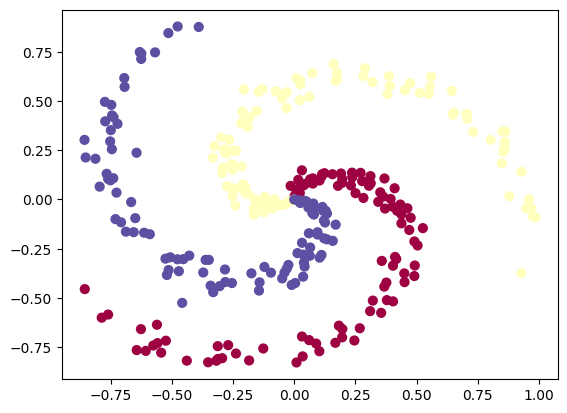

In [ ]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
X[5], y[5]

(array([0.00996794, 0.04951162]), 0)

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=43)

In [ ]:
import torch
from torch import nn
Xtrain = torch.from_numpy(Xtrain).type(torch.float32)
ytrain = torch.from_numpy(Ytrain).type(torch.float32)
Xtest = torch.from_numpy(Xtest).type(torch.float32)
Ytest = torch.from_numpy(Ytest).type(torch.float32)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
inp_f = 2
opt_f = 3
hid_u = 20
class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers_stack = nn.Sequential(
        nn.Linear(in_features = inp_f, out_features = hid_u),
        nn.ReLU(),
        nn.Linear(in_features = hid_u, out_features = hid_u),
        nn.ReLU(),
        nn.Linear(in_features = hid_u, out_features = opt_f)
    )
  def forward(self, x):
    return self.layers_stack(x)

model = SpiralModel().to(device)
model

SpiralModel(
  (layers_stack): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
  )
)

In [ ]:
Xtrain.shape

torch.Size([240, 2])

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001)

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

In [ ]:
epochs = 1000

for epoch in range(epochs):
  model.train()
  trainLogits = model(Xtrain)
  trainPreds = torch.softmax(trainLogits, dim=1).argmax(dim=1)
  trainLoss = loss_fn(trainLogits, Ytrain)
  train_acc = torchmetrics_accuracy(trainPreds, Ytrain)
  optimizer.zero_grad()
  trainLoss.backward()
  optimizer.step()

  model.eval()

  with torch.inference_mode():
    testLogits = model(Xtest)
    testPreds = torch.softmax(testLogits, dim=1).argmax(dim=1)
    testLoss = loss_fn(testLogits, Ytest)
    test_acc = torchmetrics_accuracy(testPreds, Ytest)
  if epoch%10==0:
    print(f"Epoch : {epoch} | Train Loss : {trainLoss:.5f} | Train Accuracy : {train_acc*100:.2f}% | Test Loss : {testLoss:.5f} | Test Accuracy : {test_acc*100:.2f}%")

Epoch : 0 | Train Loss : 1.09237 | Train Accuracy : 42.50% | Test Loss : 1.09571 | Test Accuracy : 40.00%
Epoch : 10 | Train Loss : 1.07646 | Train Accuracy : 46.67% | Test Loss : 1.07835 | Test Accuracy : 43.33%
Epoch : 20 | Train Loss : 1.06000 | Train Accuracy : 54.17% | Test Loss : 1.05906 | Test Accuracy : 50.00%
Epoch : 30 | Train Loss : 1.04177 | Train Accuracy : 60.42% | Test Loss : 1.03726 | Test Accuracy : 65.00%
Epoch : 40 | Train Loss : 1.02195 | Train Accuracy : 57.92% | Test Loss : 1.01387 | Test Accuracy : 66.67%
Epoch : 50 | Train Loss : 0.99983 | Train Accuracy : 55.42% | Test Loss : 0.98732 | Test Accuracy : 66.67%
Epoch : 60 | Train Loss : 0.97539 | Train Accuracy : 54.17% | Test Loss : 0.95864 | Test Accuracy : 65.00%
Epoch : 70 | Train Loss : 0.94873 | Train Accuracy : 55.42% | Test Loss : 0.92783 | Test Accuracy : 66.67%
Epoch : 80 | Train Loss : 0.92010 | Train Accuracy : 55.42% | Test Loss : 0.89471 | Test Accuracy : 66.67%
Epoch : 90 | Train Loss : 0.89029 | Tr